In [2]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 44.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

#TensorFlow
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
#PB SUR MAC M1
import tensorflow_text

#Splitting
from sklearn.model_selection import train_test_split

#Scoring
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, accuracy_score

#Graphes
import matplotlib.pyplot as plt

In [4]:
#Récupération du DataSet
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv",encoding = "ISO-8859-1")
#On renseigne les NAN avec des chaines vides
dataset = dataset.fillna('')
#Concatenation des colonnes
dataset['content'] = dataset.iloc[:,1] + dataset.iloc[:,2] + dataset.iloc[:,3] + dataset.iloc[:,4]
#Suppression des colonnes 
dataset.drop(columns=['v2','Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True,axis=1)
#rename de la colonne
dataset.rename(columns={'v1':'target'},inplace=True)
#Création target format numérique 
dataset['num_target'] = 0
dataset.loc[dataset['target'] == 'spam','num_target'] = 1

In [5]:
dataset.head()

,target,content,num_target
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [6]:
#Chargement du model de preprocess BERT
bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#A la sortie c'est un dictionnaire avec 3 elements 

#Chargement d'un model BERT SMALL 
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",trainable=False, name="bert")

In [7]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprossessing = bert_preprocess_model(text_input)
bert_outputs = bert_model(preprossessing)
bert_pooled_outputs = bert_outputs['pooled_output']
dense_layer = tf.keras.layers.Dense(64, activation="relu")(bert_pooled_outputs)
final_outputs = tf.keras.layers.Dense(1, activation="sigmoid")(dense_layer)
model_bert = tf.keras.Model(inputs=text_input, outputs=final_outputs)
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['input_1[0][0]']                
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [8]:
#On compile le modele (legacy utilisé car mac M1)
model_bert.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [9]:
#Meme découpage que pour les autres models 
train_set,val_set,label_train_set,label_val_set = train_test_split(dataset['content'],dataset['num_target'],test_size=0.1,stratify=dataset['num_target'])
train_set,test_set,label_train_set,label_test_set = train_test_split(train_set,label_train_set,test_size=0.2,stratify=label_train_set)


In [10]:
#Entrainement 
model_bert.fit(train_set,label_train_set,
          epochs=50, 
          validation_data=(val_set,label_val_set))

Epoch 1/50
126/126 [==============================] - 19s 127ms/step - loss: 0.2105 - binary_accuracy: 0.9132 - val_loss: 0.1199 - val_binary_accuracy: 0.9606
Epoch 2/50
126/126 [==============================] - 16s 131ms/step - loss: 0.1274 - binary_accuracy: 0.9559 - val_loss: 0.1006 - val_binary_accuracy: 0.9695
Epoch 3/50
126/126 [==============================] - 16s 129ms/step - loss: 0.1059 - binary_accuracy: 0.9656 - val_loss: 0.0790 - val_binary_accuracy: 0.9731
Epoch 4/50
126/126 [==============================] - 17s 134ms/step - loss: 0.0955 - binary_accuracy: 0.9686 - val_loss: 0.0737 - val_binary_accuracy: 0.9731
Epoch 5/50
126/126 [==============================] - 15s 121ms/step - loss: 0.0931 - binary_accuracy: 0.9706 - val_loss: 0.0688 - val_binary_accuracy: 0.9803
Epoch 6/50
126/126 [==============================] - 16s 127ms/step - loss: 0.0885 - binary_accuracy: 0.9716 - val_loss: 0.0696 - val_binary_accuracy: 0.9785
Epoch 7/50
126/126 [==========================

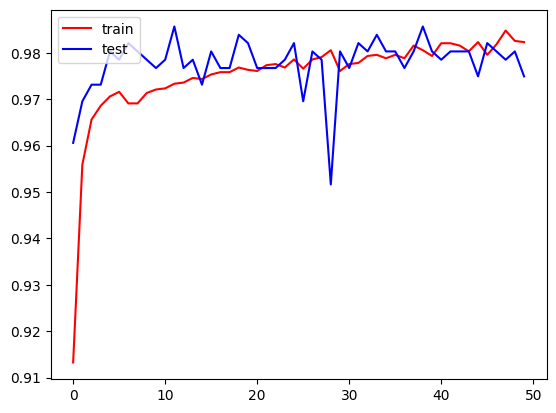

In [12]:
#Trace la courbe d'accuracy
plt.plot(model_bert.history.history["binary_accuracy"], c="r", label="train")
plt.plot(model_bert.history.history["val_binary_accuracy"], c="b", label="test")
plt.legend(loc="upper left")
plt.show()

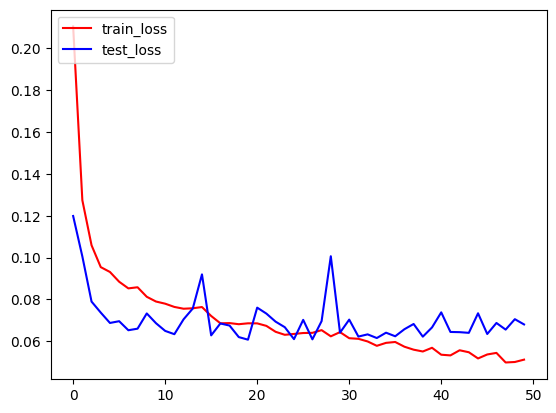

In [13]:
# Trace la loss
plt.plot(model_bert.history.history["loss"], c="r", label="train_loss")
plt.plot(model_bert.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

32/32 [==============================] - 8s 209ms/step


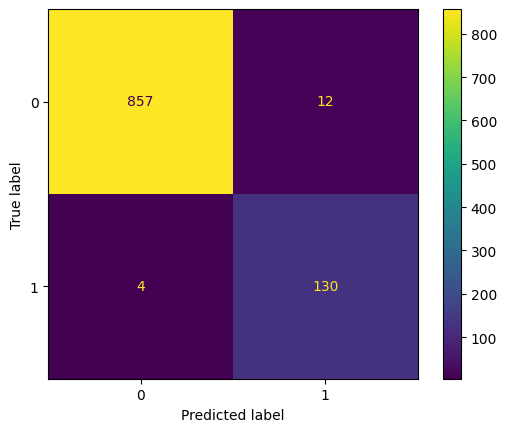

In [14]:
#disp = ConfusionMatrixDisplay
cm_all_car = confusion_matrix(label_test_set, np.round(model_bert.predict(test_set)))
disp_all_car = ConfusionMatrixDisplay(confusion_matrix=cm_all_car)
disp_all_car.plot()
plt.show()

Le modele est bon mais pas aussi bon que le USE, il reste 16 sms non correctement classé. A tester avec un plus gros model BERT et plus de data